# Workspace \#7: ``model.py``

In [4]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from random import random

import sys
sys.path.insert(0, '../')

import constants as ct
import particle as pt
import astro as ap
import echo as ec
import routines as rt
import data as dt
import model as md

In [6]:
# The contents of model.py
dir(md)

['__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'ap',
 'ct',
 'ec',
 'np',
 'pt',
 'rt',
 'snr_routine']

In [7]:
# defining a test SNR
test_snr = dt.SuperNovaRemnant()
test_snr.__dict__ = {
    'Lpk': 10**(25.5+1.6*2),
    'age': 1.e3,
    'alpha': 0.5,
    'ang_size': None,
    'b': 0.,
    'distance': 0.1,
    'is_complete': False,
    'is_flux_certain': False,
    'is_spectral_certain': False,
    'is_type_certain': True,
    'l': 178.,
#     'l': 2.,
    'name': 'test',
    'no_dist': False,
    'no_flux': False,
 #'snu_at_1GHz': 160.0,
 #'snu_at_1GHz': 50,
#     'sr': 1e-05,
    'tpk': 10**1.7,
    'type': 'S'}

../echo.py:1268: RuntimeWarning: divide by zero encountered in true_divide
  return ga_ref * sqrt(sn_val/sn_ref)
/home/buenabad/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


('ga_arr:', array([8.26862983e-11, 7.54638301e-11, 7.37330066e-11, 8.26266335e-11,
       1.09302442e-10, 1.61836802e-10, 2.51712418e-10, 3.98250501e-10,
       6.33528510e-10,            inf]))


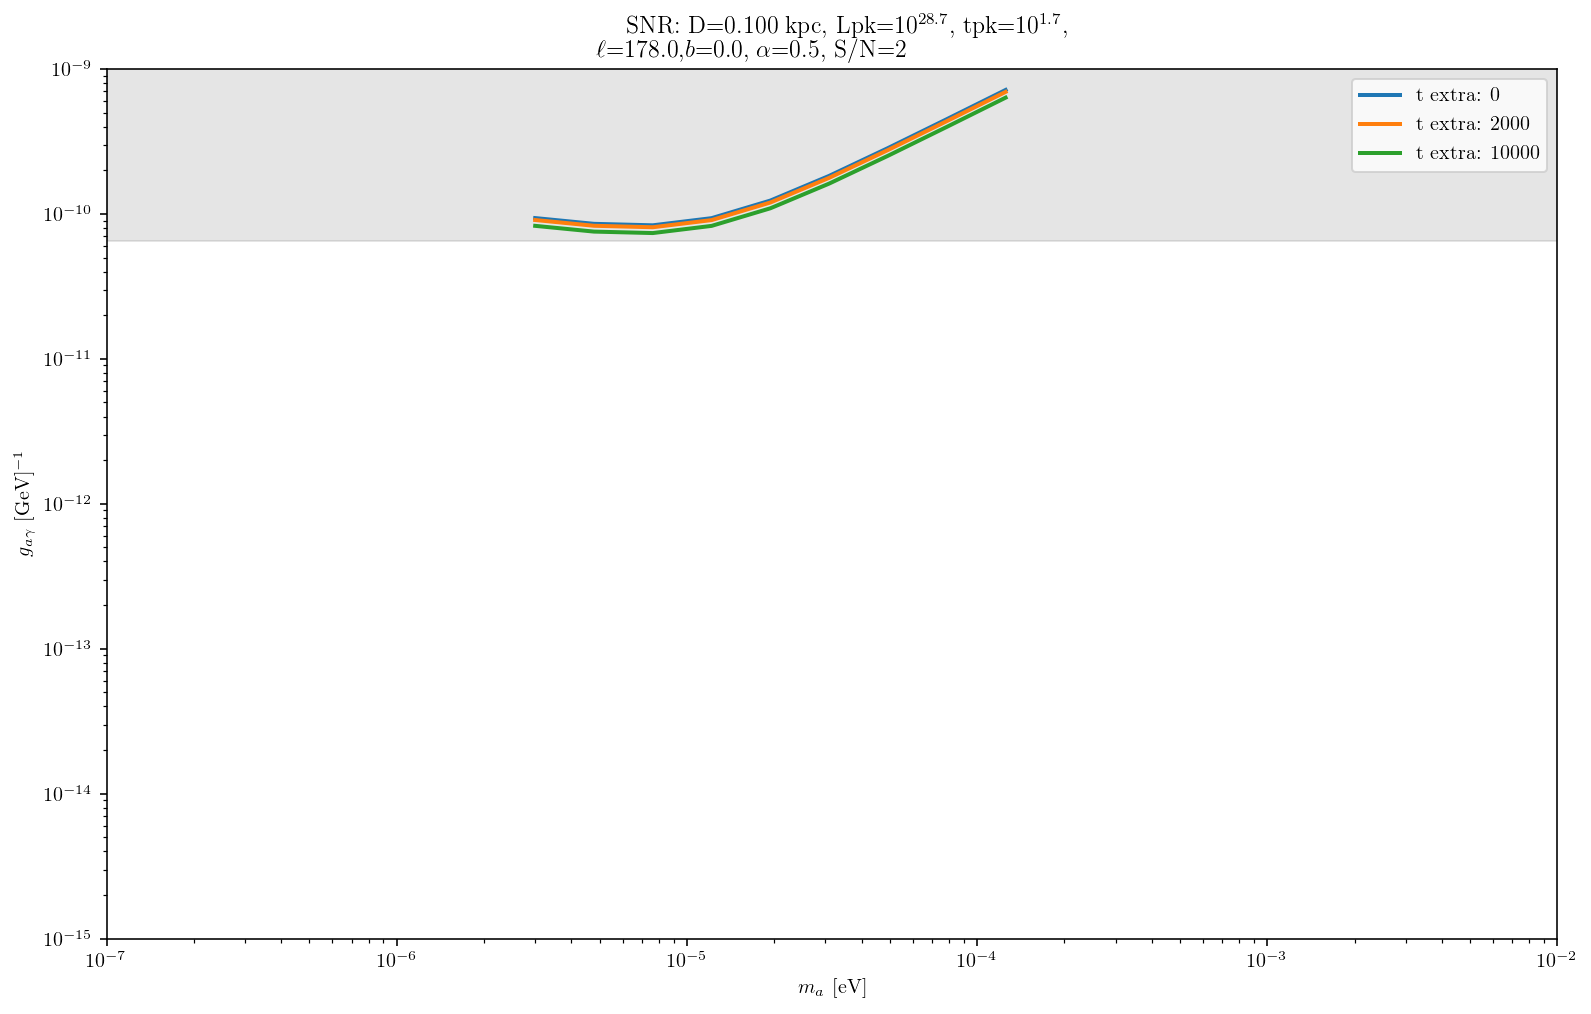

In [8]:
# t_extra_old = 5.e4
t_extra_arr = [0., 2000., 1.e4]
t_age = None #set in snr.__dict__
t_trans_over_t_peak = 30.
ma_arr = np.logspace(np.log10(3e-6), np.log10(2e-4), 10)
sig_noi_thres = 2.
ga_ref = 1.e-10 # doesn't matter, will be rescaled

counter = 0
best_snr = None
best_ga = 1.# at first ma point

plt.subplots()
#for _, snr in tqdm(snrs_dct.items(), total=len(snrs_dct.keys())):

for idx, t_extra_old in enumerate(t_extra_arr):
    color = 'C'+str(idx)
    for snr in [test_snr]:
        
        try:
            distance = snr.get_distance()

        except:
            continue
        
        L_peak = snr.Lpk
        t_peak = snr.tpk
        
        tage = snr.age
        snu_echo_kwargs = {'tmin_default':None,
                           'Nt':int(30*tage + 1), # for a fine enough array
                           'xmin':ct._au_over_kpc_,
                           'xmax_default':100.,
                           'use_quad':False,
                           'lin_space':False,
                           'Nint':int(30*tage + 1), # for a fine enough array
                           't_extra_old':t_extra_old
                          }
        # data:
        data = {'deltaE_over_E':1.e-3,
                'f_Delta':0.721,
                'exp':'SKA',
                'total_observing_time':100.,
                'verbose':0, 
                'average':True
               }
        
        t_trans=t_trans_over_t_peak*(t_peak/365)
        
        lightcurve_params = {'t_peak':t_peak,
                             'L_peak':L_peak,
                             't_age':tage,
                             't_trans':t_trans
                            }
        
        sig_noi = md.snr_routine(ma_arr, ga_ref,
                                 snr,
                                 lightcurve_params=lightcurve_params,
                                 snu_echo_kwargs=snu_echo_kwargs,
                                 data=data,
                                 output_all=False)
        
        ga_arr = ec.ga_reach(sig_noi_thres, sig_noi, ga_ref)
        
        plt.plot(ma_arr, ga_arr, lw='2.', color=color, alpha=1., label='t extra: %d' %t_extra_old)
        counter += 1

        if best_ga > ga_arr[0]:
            best_snr = snr
            best_ga = ga_arr[0]
    #     if counter == 2:
    #         break

ga_cast = 6.5e-11
plt.fill_between([1e-7, 1e-2], ga_cast, 1, color='grey', alpha=0.2)

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-15, 1e-9)
plt.xlim(1e-7, 1e-2)
plt.xlabel('$m_a$ [eV]')
plt.ylabel('$g_{a\gamma}$ [GeV]$^{-1}$')
plt.legend(loc='best')


title_str = r"SNR: D={D:.3f} kpc, Lpk=10$^{{{log10Lpk:.1f}}}$, tpk=10$^{{{log10tpk:.1f}}}$,\\$\ell$={ell:.1f},$b$={b:.1f}, $\alpha$={alpha:.1f}, S/N={sn:.0f}"
title = title_str.format(D=snr.distance,
                         log10Lpk=np.log10(snr.Lpk), 
                         log10tpk=np.log10(snr.tpk),
                         ell=snr.l,
                         b=snr.b,
                         alpha=snr.alpha,
                         sn=sig_noi_thres)

plt.title(title)

print('ga_arr:',  ga_arr)

### Studying Green's Catalogue

In [9]:
# first let's parse snrs.list.html
# names:
# path = '../data/snr_website/www.mrao.cam.ac.uk/surveys/snrs/snrs.list.html'
snr_name_arr = dt.load_Green_catalogue_names()

# catalogue:
# pathroot = '../data/snr_website/www.mrao.cam.ac.uk/surveys/snrs/'
snrs_dct = dt.load_Green_catalogue(snr_name_arr)

G4.5+6.8 is suggested to be related to SN explosion at AD:1604
it is about 417 years old.
G7.7-3.7 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G11.2-0.3 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G69.0+2.7 is suggested to be related to SN explosion at AD:1408
it is about 613 years old.
G111.7-2.1 could be related to  a late 17th century SN.
it is about 321 years old.
G120.1+1.4 is suggested to be related to SN explosion at AD:1572
it is about 449 years old.
G130.7+3.1 is suggested to be related to SN explosion at AD:1181
it is about 840 years old.
G184.6-5.8 is suggested to be related to SN explosion at AD:1054
it is about 967 years old.
G315.4-2.3 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G320.4-1.2 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G327.6+14.6 is suggested to be related to SN explosion at AD:1006
it is about 1015 years old.


In [10]:
for name, snr in snrs_dct.items():
    try:
        print sn_remnant.age
    except:
        continue

In [11]:
snrs_cut = {}
for name, snr in snrs_dct.items():
    
    try:
        snr.distance
    except:
#         print "no distance:", name
        continue
    
    try:
        snr.alpha
    except:
        continue
    
    if snr.get_flux_density() == -1:
        print("no flux density: "+name)
        continue
    
    if not snr.is_flux_certain:
        print("uncertain flux: "+name)
        continue
    
    snrs_cut[name] = snr
    
print(len(snrs_cut))

uncertain flux: G49.2-0.7
uncertain flux: G39.7-2.0
no flux density: G85.9-0.6
no flux density: G181.1+9.5
uncertain flux: G344.7-0.1
uncertain flux: G32.8-0.1
uncertain flux: G327.4+0.4
uncertain flux: G330.2+1.0
uncertain flux: G82.2+5.3
uncertain flux: G316.3-0.0
uncertain flux: G350.1-0.3
uncertain flux: G320.4-1.2
uncertain flux: G5.4-1.2
no flux density: G85.4+0.7
61


In [12]:
snrs_age = {}
for name, snr in snrs_cut.items():
    try:
        sn_remnant.age
    except:
        continue
    
    snrs_age[name] = sn_remnant.age

print(snrs_age)

{}


In [13]:
snrs_dct['G85.9-0.6'].__dict__

{'alpha': 0.2,
 'ang_size': 24.0,
 'b': -0.6,
 'distance': 4.8,
 'is_complete': False,
 'is_flux_certain': False,
 'is_spectral_certain': True,
 'is_type_certain': True,
 'l': 85.9,
 'name': 'G85.9-0.6',
 'no_dist': False,
 'no_flux': True,
 'sr': 3.827931505771323e-05,
 'type': 'S'}

In [14]:
# computing the mean, std, min, and max of the SNR distances

dists = np.array([snr.distance for name, snr in snrs_dct.items() if not snr.no_dist])

print("No. of distances: {}".format(len(dists)))
print("mean:\t{} kpc\nstd:\t{} kpc\nmin:\t{} kpc\nmax:\t{} kpc".format(dists.mean(), dists.std(), dists.min(), dists.max()))

No. of distances: 90
mean:	4.74627777778 kpc
std:	3.26770727993 kpc
min:	0.275 kpc
max:	17.4 kpc


In [15]:
# computing the mean, std, min, and max of the SNR distances with certain flux

dists = np.array([snr.distance for name, snr in snrs_cut.items()])

print("No. of distances: {}".format(len(dists)))
print("mean:\t{} kpc\nstd:\t{} kpc\nmin:\t{} kpc\nmax:\t{} kpc".format(dists.mean(), dists.std(), dists.min(), dists.max()))

No. of distances: 61
mean:	5.08114754098 kpc
std:	3.60414337989 kpc
min:	0.7 kpc
max:	17.4 kpc


In [16]:
snrs_cut['G108.2-0.6'].__dict__

{'alpha': 0.5,
 'ang_size': 61.48170459575759,
 'b': -0.6,
 'distance': 3.2,
 'is_complete': False,
 'is_flux_certain': True,
 'is_spectral_certain': True,
 'is_type_certain': True,
 'l': 108.2,
 'name': 'G108.2-0.6',
 'no_dist': False,
 'no_flux': False,
 'snu_at_1GHz': 8.0,
 'sr': 0.0002512065862179927,
 'type': 'S'}

In [17]:
snrs_cut['G108.2-0.6'].get_flux_density()

8.0

In [18]:
snr.__dict__

{'alpha': 0.36,
 'ang_size': 45.0,
 'b': 3.0,
 'distance': 1.9,
 'is_complete': False,
 'is_flux_certain': True,
 'is_spectral_certain': True,
 'is_type_certain': True,
 'l': 189.1,
 'name': 'G189.1+3.0',
 'no_dist': False,
 'no_flux': False,
 'snu_at_1GHz': 165.0,
 'sr': 0.00013457537324746528,
 'type': 'C'}

In [19]:
verbose = 2
snr_results = {}

ga_ref = 1.e-10

tpk = 10.**(1.7)
Lpk = 10.**(28.)
t_trans_over_t_peak = 30.
t_trans = (tpk/365.)*t_trans_over_t_peak

for name, snr in snrs_cut.items():
    
    lightcurve_params = {'t_peak':tpk,
                         'L_peak':Lpk,
                         't_trans':t_trans}
    
    snu_echo_kwargs = {'tmin_default':None,
                       'Nt':int(30001),
                       'xmin':ct._au_over_kpc_,
                       'xmax_default':100.,
                       'use_quad':False,
                       'lin_space':False,
                       'Nint':int(30001),
                       't_extra_old':0.
                      }
    # data:
    data = {'deltaE_over_E':1.e-3,
            'f_Delta':0.721,
            'exper':'SKA',
            'total_observing_time':100.,
            'verbose':0,
            'average':True
           }
    
    z, new_output = md.snr_routine(pt.ma_from_nu(1.), ga_ref,
                                   snr,
                                   lightcurve_params=lightcurve_params,
                                   snu_echo_kwargs=snu_echo_kwargs,
                                   data=data,
                                   output_all=True,
                                   verbose=verbose)
    
    snr_results[name] = new_output
    
    # obtaining L_today
    area = 4.*pi*(snr.distance*ct._kpc_over_cm_)**2. # [cm^2]
    L0 = (snr.snu_at_1GHz*ct._Jy_over_cgs_irrad_)*area # [cgs]
    # computing t_age [years]
    print(ap.tage_compute(Lpk,
                          tpk,
                          t_trans,
                          L0,
                          ap.gamma_from_alpha(snr.alpha)))

SNR size=3.2e-06. Value will be respected.
signal power:1.73786966042e-19
noise power:9.61555148409e-17
s/n: 0.00180735308141

201.24038422609357
SNR size=3.3e-07. Value will be respected.
signal power:7.73253902268e-20
noise power:4.33292794766e-17
s/n: 0.00178459903236

64.69820769988002
SNR size=1.1e-06. Value will be respected.
signal power:5.38173579029e-19
noise power:5.46087780197e-17
s/n: 0.00985507456026

202.57146849074974
SNR size=6.4e-06. Value will be respected.
signal power:3.06787028466e-19
noise power:1.64083464194e-16
s/n: 0.00186970106935

264.83602763931225
SNR size=1.9e-05. Value will be respected.
signal power:1.08605408185e-19
noise power:2.46517624994e-16
s/n: 0.000440558390856

97.34612327216263
SNR size=4.3e-06. Value will be respected.
signal power:2.54979366639e-19
noise power:1.07653328229e-16
s/n: 0.00236852283932

337.2560003630851
SNR size=6.1e-05. Value will be respected.
signal power:1.33642044398e-18
noise power:4.04846242532e-16
s/n: 0.00330105680522


In [20]:
max([res['S/N'] for name, res in snr_results.items()])

0.02204701308225571